# model.fit에서 벗어나기

**데이터셋** : Yoga Dataset -> [Link](https://www.kaggle.com/datasets/niharika41298/yoga-poses-dataset?resource=download&select=DATASET)
- 해당 데이터셋에는 따로 Validation set이 없기 때문에 이를 분리해줍니다.

In [1]:
import os
import random

data_path = './model-fit/data/DATASET/TRAIN'
cls = [os.path.join(data_path, x) for x in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, x))]
cls

['./model-fit/data/DATASET/TRAIN/downdog',
 './model-fit/data/DATASET/TRAIN/goddess',
 './model-fit/data/DATASET/TRAIN/plank',
 './model-fit/data/DATASET/TRAIN/tree',
 './model-fit/data/DATASET/TRAIN/warrior2']

In [2]:
cls_files = {}

for x in cls:
    if x not in cls_files:
        cls_files[x] = [f for f in os.listdir(x) if os.path.isfile(os.path.join(x, f))]
        
cls_files['./model-fit/data/DATASET/TRAIN/downdog'][:5]

['00000274.jpg',
 '00000238.jpg',
 '00000199.jpg',
 '00000263.jpg',
 '00000308.jpg']

In [3]:
import random
import copy
import shutil

cls_val = {}
# 0.8, 0.2 비율로 기존의 TRAIN 셋을 나눠봅시다.
for x in cls:
    n_train_data = int(len(cls_files[x]) * 0.8) # train 비율 0.8
    n_val_data = len(cls_files[x]) - n_train_data # validation 비율 0.2
    print(len(cls_files[x]), n_train_data, n_val_data)
    train_data = random.sample(cls_files[x], n_train_data)
    val_data = copy.deepcopy(cls_files[x]) 
    
    for y in train_data: # TRAIN 폴더에서 VAL 폴더로 옮겨줄 데이터만 남기기
        val_data.remove(y)
        
    print(len(cls_files[x]), len(train_data), len(val_data))
    
    # 현재 클래스 디렉토리 생성
    x_cls = os.path.join('./model-fit/data/DATASET/VAL', x.split('/')[-1])
    os.makedirs(x_cls, exist_ok=True)
    for y in val_data:
        shutil.move(os.path.join(x, y), os.path.join(x_cls, y))
#         print(os.path.join(x, y), os.path.join(x_cls, y))

223 178 45
223 178 45
180 144 36
180 144 36
266 212 54
266 212 54
160 128 32
160 128 32
252 201 51
252 201 51


## 데이터 불러오기

- 딥러닝 모델 학습에 필요한 것 : 데이터, 모델, loss 함수, optimizer


먼저 데이터를 불러와야된다. 이 때 아래의 두 가지 방법이 존재한다.
1. `ImageDataGenerator` : 원하는 배치 사이즈 만큼 쉽게 불러와서 resize도 쉽다.
2. `tf.data` : Tensorflow가 감당하기 큰 사이즈의 데이터를 불러오기 쉽고 재사용 가능한 조각으로 복잡한 입력 파이프라인을 구축할 수 있다.
    - **큰 사이즈 데이터를 로드하기 좋다.**

In [4]:
!pip3 install tensorflow-estimator==2.6.0 -qq

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-gpu 2.6.0 requires numpy~=1.19.2, but you have numpy 1.21.4 which is incompatible.
tensorflow-gpu 2.6.0 requires six~=1.15.0, but you have six 1.16.0 which is incompatible.
tensorflow-gpu 2.6.0 requires typing-extensions~=3.7.4, but you have typing-extensions 4.0.1 which is incompatible.


In [5]:
import pathlib
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


def process_path(file_path, class_names, img_shape=(224, 224)):
    '''
    file_path로부터 class label을 만들고, 이미지를 읽는 함수
    '''
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label

In [6]:
def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    '''
    TensorFlow Data API를 이용해 data batch를 만드는 함수
    '''
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

In [7]:
def load_label(data_path):
    '''
    class 이름을 가져오는 함수
    '''
    class_names = [str(x) for x in data_path.iterdir]
    print("Find {} class : {}".format(len(class_names), class_names))
    return np.array(class_names)

In [8]:
def show_batch(image_batch, label_batch, class_names):
    '''
    데이터를 시각화해주는 함수
    '''
    size = len(image_batch)
    sub_size = size
    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.rc('font', size=10)
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        print(plt.title(class_names[label_batch[n]==True][0].title()))
        plt.title(label_batch[n].numpy().decode('utf-8'))
        plt.imshow(image_batch[n])
    plt.show()

In [9]:
def load_data(data_path, batch_size=32):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=(224, 224)))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    return ds

In [11]:
data_path = './model-fit/data/DATASET/TRAIN' 
train_dataset = load_data(data_path, batch_size=6)
data_dir = pathlib.Path(data_path)
class_names = load_label(data_dir)

for img, label in train_dataset.take(5):
    show_batch(img, label, class_names)

TypeError: 'method' object is not iterable

- 제대로 실행되지 않았음을 볼 수 있다.
- 한 번 이미지 데이터를 확인해본다.

In [12]:
import glob
from PIL import Image

data_path = './model-fit/data/DATASET/TRAIN'
extensions = ['.jpg', '.png', '.jpeg']

for i, img_path in enumerate(glob.glob(os.path.join(data_path, '*/*'))):
    try:
        img = Image.open(img_path)
        img.verify()
    except Exception:
        print('Invalid image') # 문제가 있는 이미지가 나타나면 오류 출력

- 따로 이미지 데이터에는 문제가 없는 것으로 보인다.
- 따라서 jpeg 이미지를 디코딩해서 오류가 나는 파일을 모으는 방식으로 이를 처리한다.

In [13]:
from struct import unpack
import tqdm


marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}


class JPEG:
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        


bads = []

for img in glob.glob(os.path.join(data_path, '*/*')):
    image = JPEG(img) 
    try:
        image.decode()   
    except:
        bads.append(img)

print(bads)

['./model-fit/data/DATASET/TRAIN/tree/00000181.jpg']


- 문제있는 데이터를 제거합니다.

In [14]:
for bad in bads:
    os.remove(bad)

In [15]:
def process_path(file_path, class_names, img_shape=(224, 224)):
    '''
    file_path로 부터 class label을 만들고, 이미지를 읽는 함수
    '''
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label


def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    '''
    TensorFlow Data API를 이용해 data batch를 만드는 함수
    '''
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


def load_label(data_path):
    '''
    class 이름을 가져오는 함수
    '''
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)


def show_batch(image_batch, label_batch, class_names):
    size = len(image_batch)
    sub_size = int(size ** 0.5) + 1

    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        plt.title(class_names[np.array(label_batch[n])==True][0].title().split('/')[-1])
        plt.imshow(image_batch[n])
    plt.show()
    

def load_data(data_path, batch_size=32):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)
    
#     for item in data_path.glob("*"):
#         print(item.name)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=(224, 224)))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    return ds

Find 5 class : ['model-fit/data/DATASET/TRAIN/downdog', 'model-fit/data/DATASET/TRAIN/goddess', 'model-fit/data/DATASET/TRAIN/plank', 'model-fit/data/DATASET/TRAIN/tree', 'model-fit/data/DATASET/TRAIN/warrior2']


Corrupt JPEG data: premature end of data segment


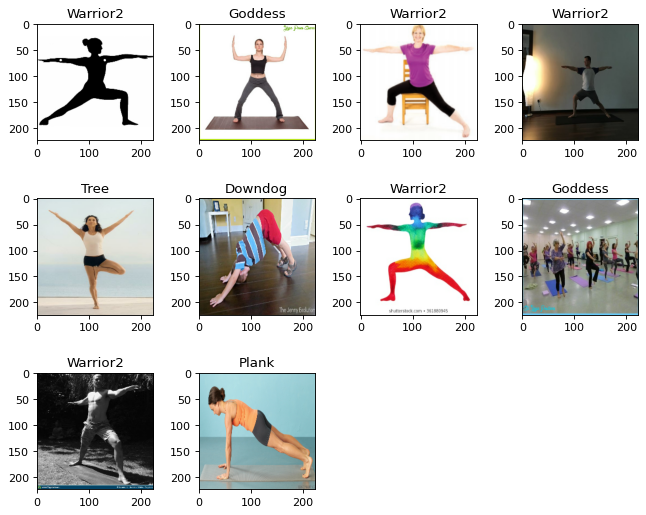

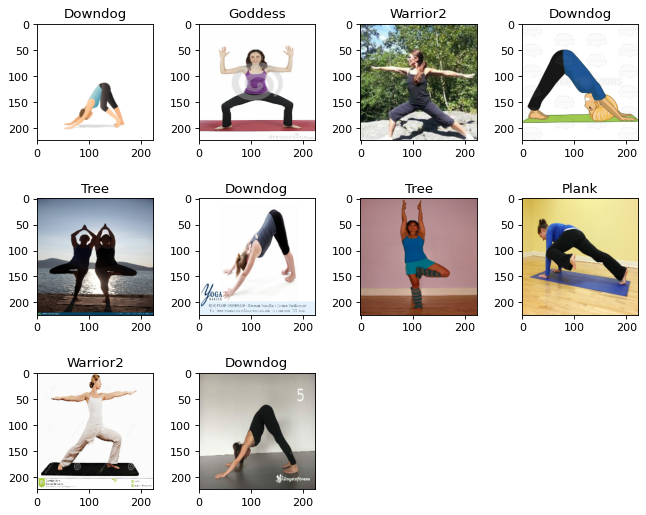

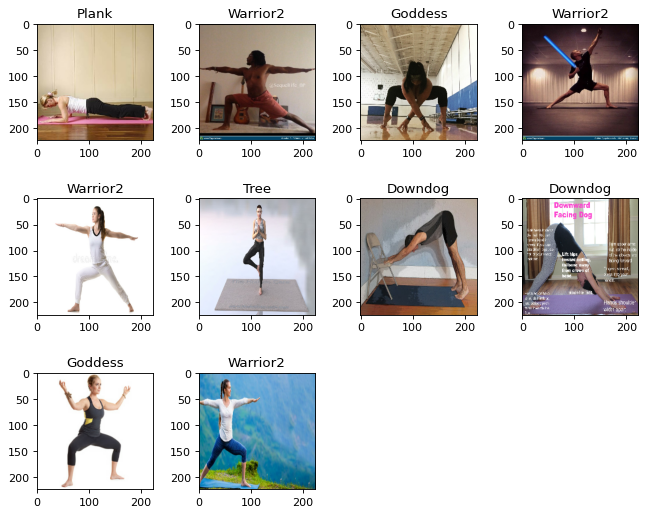

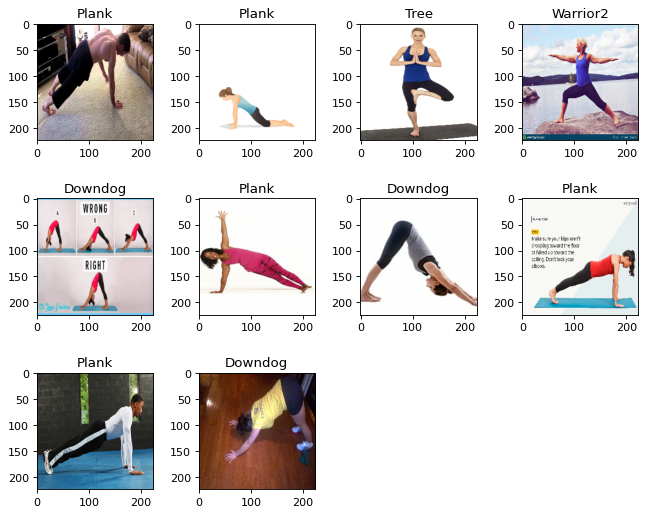

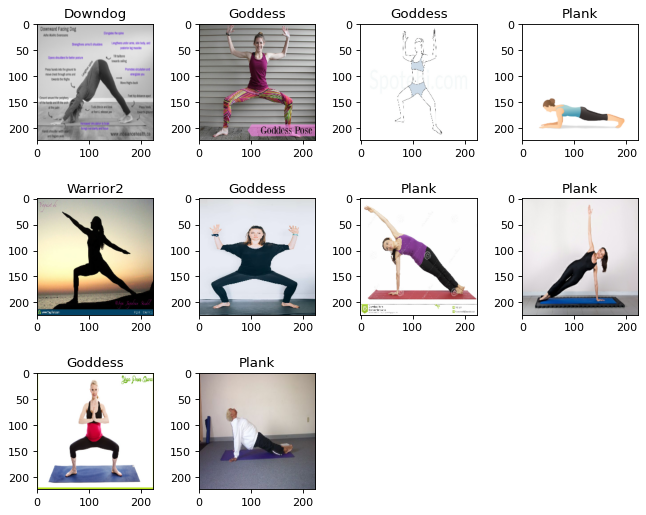

In [16]:
data_path = './model-fit/data/DATASET/TRAIN'
train_dataset = load_data(data_path, batch_size=10)
data_dir = pathlib.Path(data_path)
class_names = load_label(data_dir)

for img, label in train_dataset.take(5):
    show_batch(img, label, class_names)

### 코드 살펴보기

- [참고문헌](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)


#### 1. tf.data.Dataset.list_files
- data_dir의 하위의 모든 파일을 가져오는 역할

In [17]:
data_dir = './model-fit/data/DATASET/TEST'
data_dir = pathlib.Path(data_path)

list_ds = tf.data.Dataset.list_files(str(data_dir / '*/*'))
for f in list_ds.take(5):
    print(f.numpy())

b'model-fit/data/DATASET/TRAIN/downdog/00000403.jpg'
b'model-fit/data/DATASET/TRAIN/downdog/00000345.png'
b'model-fit/data/DATASET/TRAIN/plank/00000333.jpg'
b'model-fit/data/DATASET/TRAIN/tree/00000165.jpg'
b'model-fit/data/DATASET/TRAIN/goddess/00000113.jpg'


#### 2. list_ds.map(lambda x: process_path(x, class_names))

- 코드에서는 process_path라는 함수로 변환을 적용하게 만들었는데, 라벨과 이미지에 대한 변환을 적용했다는 것을 알 수 있다. 
- resize 외에도 다양한 augmentation 코드를 추가해볼 수 있다.

In [18]:
def process_path(file_path, class_names, img_shape=(224, 224)):
    label = tf.strings.split(file_path, os.path.sep) # file path parse해서 라벨 얻기 
    label = label[-2] == class_names # 라벨 인코딩

    img = tf.io.read_file(file_path) # 이미지 읽기
    img = tf.image.decode_jpeg(img, channels=3) # 이미지 파일 디코딩
    img = tf.image.convert_image_dtype(img, tf.float32) # 이미지 타입 변환
    img = tf.image.resize(img, img_shape) # 이미지 사이즈 변환
    return img, label
    
labeled_ds = list_ds.map(lambda x: process_path(x, class_names))
labeled_ds

<MapDataset shapes: ((224, 224, 3), (5,)), types: (tf.float32, tf.bool)>

#### 3. cache(), shuffle(), repeat(), batch(), prefetch() 함수

#### 1) `ds.cache()`<br>
- 데이터셋을 메모리에 저장해 두고, 두 번째 이터레이션부터는 캐시된 데이터를 사용하여 시간을 아낄 수 있습니다. 
- Epoch 동안 실행되는 일부 작업(예: 파일 열기 및 데이터 읽기)이 저장됩니다.

#### 2) `ds.shuffle(buffer_size=shuffle_buffer_size)` <br>
- 데이터셋을 섞어(shuffle) 줍니다. 
- BUFFER_SIZE 만큼 임의로 샘플을 뽑고, 이 버퍼에서 랜덤하게 하나씩 나갈 때마다 원본 데이터 셋에서 아이템을 꺼내 다시 버퍼를 채웁니다. 
- 완벽한 셔플링을 위해서는 데이터셋의 전체 크기보다 크거나 같은 버퍼 크기가 필요합니다.

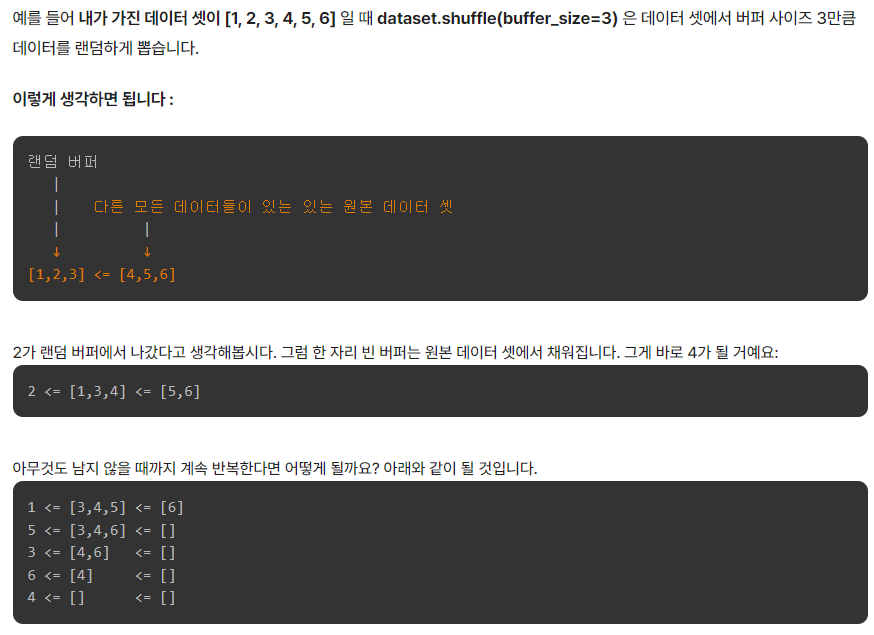


#### 3) `ds.repeat()`<br>
- 데이터셋을 반복하여 생성합니다. 
- repeat 함수에 arguments로 반복하고 싶은 수를 넣어주지 않으면 무한히 반복합니다. 
- 따라서 코드가 멈춰야할 때를 결정해야 합니다.

#### 4) `ds.batch(batch_size)`<br>
- batch 함수는 batch_size 만큼의 배치로 알아서 묶어줍니다. 
- 주의할 점은 ds.repeat()는 ds.batch() 호출 이전에 있어야 한다는 점입니다. 
- 그래야 생성된 데이터를 batch_size 만큼 묶어줄 수 있기 때문이죠.

#### `5) ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)`<br>
- 학습 중일 때, **데이터 로드 시간을 줄이기 위해 데이터를 미리 메모리에 적재**시켜 둡니다. 
- 즉, 모델이 **step s를 실행하는 동안 입력 파이프라인은 step s+1의 데이터를 미리 읽습니다.**
- 대부분의 `dataset input` 파이프라인은 **prefetch 호출로 끝나야 합니다.**
- prefetch(n)이라고 한다면 n 배치 만큼을 모델이 학습하는 동안 동시에 메모리에 적재시키게 됩니다. 
- 데이터 로드 시간이 줄면 **전체 학습 시간이 줄어드는 효과**가 있습니다.

In [19]:
def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000, n_repeat=3):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat(n_repeat)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

## EfficientNet 구조 알아보기  
[EfficientNet](https://arxiv.org/abs/1905.11946)

-  AutoML을 이용하여 depth, channel, resolution(input image size)의 최적의 조합을 찾고자 했다.

-  EfficientNet은 우리가 사용할 B0부터 B7이 있으며, 0에서 7로 갈수록 파라미터 갯수도 많아지고 image resolution도 커진다.

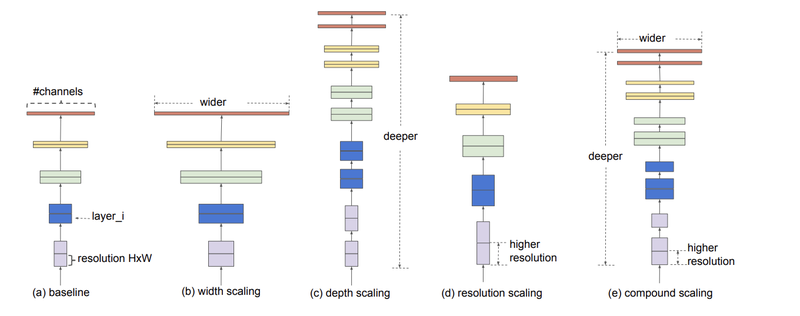

## EfficientNetB0 사용하기

In [20]:
from tensorflow.keras.applications import EfficientNetB0

class YogaPose(tf.keras.Model):
    '''
    EfficientNetB0을 백본으로 사용하는 모델을 구성합니다.
    Classification 문제로 접근할 것이기 때문에 맨 마지막 Dense 레이어에 
    우리가 원하는 클래스 갯수 만큼을 지정해주어야 합니다.
    '''
    def __init__(self, num_classes=5, freeze=False):
        super(YogaPose, self).__init__()
        self.base_model = EfficientNetB0(include_top=False, weights='imagenet')
        if freeze:
            self.base_model.trainable = False
        self.top = tf.keras.Sequential([tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"),
                                       tf.keras.layers.BatchNormalization(),
                                       tf.keras.layers.Dropout(0.5, name="top_dropout")])
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")
    def call(self, inputs, training=True):
        x = self.base_model(inputs)
        x = self.top(x)
        x = self.classifier(x)
        return x

if __name__ == '__main__':
    model = YogaPose(num_classes=5, freeze=True)
    model.build(input_shape=(None, 224, 224, 3))
    print(model.summary())

16719872/16705208 [==============================] - 0s 0us/step
Model: "yoga_pose"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
sequential (Sequential)      (None, 1280)              5120      
_________________________________________________________________
pred (Dense)                 multiple                  6405      
Total params: 4,061,096
Trainable params: 8,965
Non-trainable params: 4,052,131
_________________________________________________________________
None


## Trainer 만들기

In [21]:
class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        
    def train(self, train_dataset, train_metric):
        
        for epoch in range(self.epochs):
            print("\nStart of epoch %d" % (epoch,))
            # 매 batch 마다 반복적으로 학습
            for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                with tf.GradientTape() as tape:
                    logits = model(x_batch_train, training=True)
                    loss_value = self.loss_fn(y_batch_train, logits)
                grads = tape.gradient(loss_value, model.trainable_weights)
                self.optimizer.apply_gradients(zip(grads, model.trainable_weights))
                # train metric 업데이트
                train_metric.update_state(y_batch_train, logits)
                # 5 배치마다 로깅
                if step % 5 == 0:
                    print(
                        "Training loss (for one batch) at step %d: %.4f"
                        % (step, float(loss_value))
                    )
                    print("Seen so far: %d samples" % ((step + 1) * self.batch))
                    print(train_metric.result().numpy())
                # 마지막 epoch 학습이 끝나면 train 결과를 보여줌
            train_acc = train_acc_metric.result()
            print("Training acc over epoch: %.4f" % (float(train_acc),))

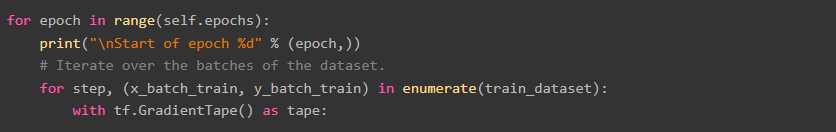

- Triner의 코드는 위와 같은 방식으로 시작한다.

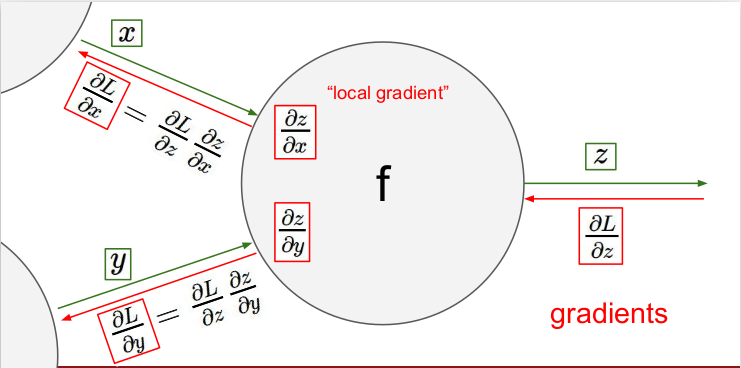
- tf.GradientTape가 BackPropagation을 해주는 것으로 생각할 수 있습니다.
- `tf.GradientTape`는 컨텍스트(context) 안에서 실행된 모든 연산을 테이프(tape)에 "기록" 합니다. 그 다음 텐서플로는 `후진 방식 자동 미분(reverse mode differentiation)`을 사용해 테이프에 “기록된” 연산의 그래디언트를 계산합니다.

In [22]:
x = tf.Variable(3.0)
with tf.GradientTape() as tape:
    y = x**2

# dy = 2x * dx
dy_dx = tape.gradient(y, x)
dy_dx.numpy()

6.0

위와 같은 이유 때문에 우리는 `tf.GradientTape`를 사용합니다.

- 모델이 예측한 값은 `logit`이 됩니다. 그리고 로스(loss) 함수로부터 true label과 모델이 **예측한 logits 사이의 loss**를 구할 수 있겠습니다. 
- 후에 `tape.gradient()`로 그라디언트를 계산하고 optimizer에 적용시켜줍니다.
- 마지막으로 `train metric.update_state`는 각 배치마다 모델을 평가하는 metric에 알맞은 값을 업데이트해줍니다.

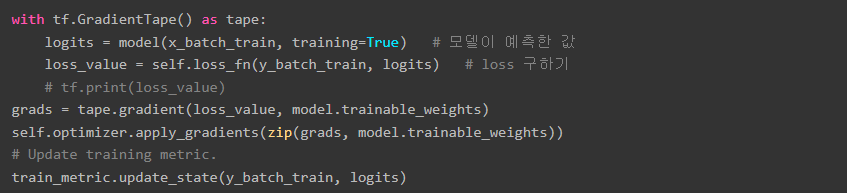

In [23]:
epoch = 1
batch = 5
model = YogaPose(num_classes=5)
dataset = load_data(data_path=data_path, batch_size=batch)
loss_function = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
trainer = Trainer(model=model,
                  epochs=epoch,
                  batch=batch,
                  loss_fn=loss_function,
                  optimizer=optimizer)

trainer.train(train_dataset=dataset,
              train_metric=train_acc_metric)


Start of epoch 0


Corrupt JPEG data: premature end of data segment


Training loss (for one batch) at step 0: 1.7204
Seen so far: 5 samples
0.4
Training loss (for one batch) at step 5: 4.1624
Seen so far: 30 samples
0.16666667
Training loss (for one batch) at step 10: 1.7164
Seen so far: 55 samples
0.29090908
Training loss (for one batch) at step 15: 1.2253
Seen so far: 80 samples
0.3625
Training loss (for one batch) at step 20: 0.6118
Seen so far: 105 samples
0.4
Training loss (for one batch) at step 25: 0.1974
Seen so far: 130 samples
0.42307693
Training loss (for one batch) at step 30: 1.0534
Seen so far: 155 samples
0.45806453
Training loss (for one batch) at step 35: 1.7852
Seen so far: 180 samples
0.5
Training loss (for one batch) at step 40: 1.7378
Seen so far: 205 samples
0.52682924
Training loss (for one batch) at step 45: 0.8584
Seen so far: 230 samples
0.5608696
Training loss (for one batch) at step 50: 2.7346
Seen so far: 255 samples
0.5686275
Training loss (for one batch) at step 55: 0.8236
Seen so far: 280 samples
0.57857144
Training loss 

1. 앞선 과정에서 아래의 세 가지를 진행했다.
    - `tf.data`를 이용한 데이터 로드
    - `tf.keras.Model`을 상속받아 나만의 모델 만들기
    - `Train loop`으로 모델 학습하기
    
2. 하지만 앞선 Train Loop으로는 얼마나 학습되고 있는지, loss가 어느 정도인지 알 수가 없고 저장도 하지 못한다.

## Train Loop에 기능 추가하기

### 1. Progbar 추가하기
- 학습이 얼마나 진행되었는지 같이 바 형태로 보여주는 것
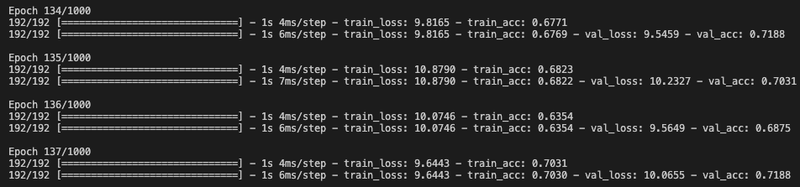


- 이전 Trainer의 train() 함수는 train_dataset, train_metric 단 두 개만을 인자로 받았습니다. 
- 그러나 이제는 각 step 별로 Progbar를 찍어주기 위해 steps_per_epoch라는 인자를 추가해줄 것입니다.
<br><br>
- 여기서 step이란 batch 1개의 loss를 계산하고 gradient를 한 번 업데이트하는 것을 말합니다. 그 step은 어떻게 구할 수 있을까요?
- 전체 학습 데이터 사이즈를 TRAIN_SIZE라고 했을 때, 그걸 batch 사이즈로 나눈 것이 step 수가 되겠죠

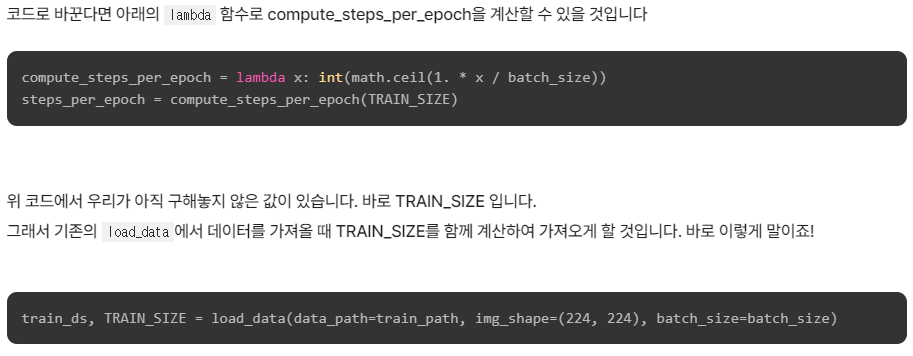

- 그러기 위해선 load_data 함수내에서 TRAIN_SIZE를 계산하도록 하여야합니다. 아래의 load_data 함수가 우리의 새로운 함수입니다.

- `tf.data.experimental.cardinality(list_ds).numpy()`을 이용해 DATASET_SIZE를 계산해서 반환해주고, img_shape를 함수의 파라미터로 넣어서 `EfficientB0` 말고도 다른 input image resolution을 갖는 모델들을 사용할 수 있게 바꿔주었습니다.

In [24]:
def load_data(data_path, img_shape, batch_size=64, is_train=True):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)
    
#     for item in data_path.glob("*"):
#         print(item.name)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=img_shape))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)
    
    DATASET_SIZE = tf.data.experimental.cardinality(list_ds).numpy()

    return ds, DATASET_SIZE

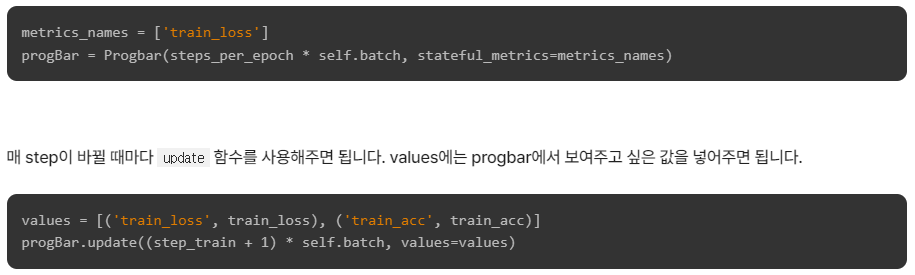

## 2. Validation 데이터 추가하기
- Validation Data가 따로 있다고 가정합니다. ( train_path, val_path가 모두 존재함을 의미한다. )
- 단순히 load_dat를 두 번 해주는 것에 지나지 않는다.
---
```python
train_ds, TRAIN_SIZE = load_data(data_path=train_path, img_shape=(224, 224), batch_size=batch_size)
val_ds, VAL_SIZE = load_data(data_path=val_path, img_shape=(224, 224), batch_size=batch_size, is_train=False)

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(TRAIN_SIZE)
val_steps = compute_steps_per_epoch(VAL_SIZE)
```
---


- 이 데이터를 train step에 넣어주기 위해선 Trainer class의 train 함수에 arguments를 늘려줘야 할 것이다.
---
```python
for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
    logits = model(x_batch_val, training=False)
    val_loss = self.loss_fn(y_batch_val, logits)
    
    # Update val metrics
    val_acc = self.compute_acc(logits, y_batch_val)
    values = [('train_loss', train_loss), ('train_acc', train_acc), ('val_loss', val_loss), ('val_acc', val_acc)]
progBar.update((step_train + 1) * self.batch, values=values, finalize=True)
```
---

In [25]:
'''
dataset.py의 코드입니다! 
'''
def process_path(file_path, class_names, img_shape=(224, 224)):
    label = tf.strings.split(file_path, os.path.sep)
    label = label[-2] == class_names

    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape)
    return img, label


def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat(1)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


def load_label(data_path):
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)


def show_batch(image_batch, label_batch, class_names):
    size = len(image_batch)
    sub_size = int(size ** 0.5) + 1

    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        plt.title(class_names[np.array(label_batch[n])==True][0].title())
        plt.imshow(image_batch[n])
    plt.show()

def load_data(data_path, img_shape, batch_size=64, is_train=True):
    '''
    데이터를 만들기 위해 필요한 함수들을 호출하고 데이터를 리턴해주는 함수
    '''
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    print(class_names)
    data_path = pathlib.Path(data_path)
    
#     for item in data_path.glob("*"):
#         print(item.name)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=img_shape))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)
    
    DATASET_SIZE = tf.data.experimental.cardinality(list_ds).numpy()

    return ds, DATASET_SIZE

In [26]:
import math

train_path = './model-fit/data/DATASET/TRAIN'
val_path = './model-fit/data/DATASET/VAL'
batch_size = 32

train_ds, TRAIN_SIZE = load_data(data_path=train_path, img_shape=(224, 224), batch_size=batch_size)
val_ds, VAL_SIZE = load_data(data_path=val_path, img_shape=(224, 224), batch_size=batch_size, is_train=False)

compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(TRAIN_SIZE)
val_steps = compute_steps_per_epoch(VAL_SIZE)

['downdog', 'goddess', 'plank', 'tree', 'warrior2']
['downdog', 'goddess', 'plank', 'tree', 'warrior2']


In [27]:
# train, val 데이터 셋 모두 (224, 224, 3) 사이즈의 input과 5개의 label에 대하여 true false로 이루어진 GT가 들어가있는지 확인합니다
train_ds, val_ds

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.bool)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None, 5)), types: (tf.float32, tf.bool)>)

#### @tf.function

- 바뀐 Trainer 클래스를 확인하기 전에 기존의 Trainer와 비교하여 train 부분은 train_on_batch 함수로 그대로 빼뒀습니다.
- train_on_batch 함수로 빼놓으면서 위에 `@tf.function` 데코레이터가 붙었다.
    - tensorflow v1에서는 graph를 생성하고 이후에 연산을 실행하는 과정을 분리했었다.
    - v2 버전에서는 사라졌기 때문에, 이를 하기 위해서 `@tf.function` 데코레이터를 붙여주면 된다.

In [28]:
from tensorflow.keras.utils import Progbar

class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def compute_acc(self, y_pred, y):
        correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        return accuracy

    @tf.function
    def train_on_batch(self, x_batch_train, y_batch_train):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)    # 모델이 예측한 결과
            train_loss = self.loss_fn(y_batch_train, logits)     # 모델이 예측한 결과와 GT를 이용한 loss 계산

        grads = tape.gradient(train_loss, model.trainable_weights)  # gradient 계산
        self.optimizer.apply_gradients(zip(grads, model.trainable_weights))  # Otimizer에게 처리된 그라데이션 적용을 요청

        return train_loss, logits

    def train(self, train_dataset, acc_metric, steps_per_epoch, val_dataset, val_step):
        metrics_names = ['train_loss', 'train_acc', 'val_loss']

        for epoch in range(self.epochs):
            print("\nEpoch {}/{}".format(epoch+1, self.epochs))

            train_dataset = train_dataset.shuffle(100)
            val_dataset = val_dataset.shuffle(100)

            train_dataset = train_dataset.take(steps_per_epoch)
            val_dataset = val_dataset.take(val_step)

            progBar = Progbar(steps_per_epoch * self.batch, stateful_metrics=metrics_names)

            train_loss, val_loss = 100, 100

            # 데이터 집합의 배치에 대해 반복합니다
            for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                train_loss, logits = self.train_on_batch(x_batch_train, y_batch_train)

                # train metric(mean, auc, accuracy 등) 업데이트
                acc_metric.update_state(y_batch_train, logits)

                train_acc = self.compute_acc(logits, y_batch_train)
                values = [('train_loss', train_loss), ('train_acc', train_acc)]
                # print('{}'.format((step_train + 1) * self.batch))
                progBar.update((step_train + 1) * self.batch, values=values)

            for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
                logits = model(x_batch_val, training=False)
                val_loss = self.loss_fn(y_batch_val, logits)
                val_acc = self.compute_acc(logits, y_batch_val)
                values = [('train_loss', train_loss), ('train_acc', train_acc), ('val_loss', val_loss), ('val_acc', val_acc)]
            progBar.update((step_train + 1) * self.batch, values=values, finalize=True)

In [30]:
loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
acc_metric = tf.keras.metrics.CategoricalAccuracy()

model = YogaPose(num_classes=5)

trainer = Trainer(model=model,
                  epochs=3,
                  batch=1,
                  loss_fn=loss_function,
                  optimizer=optimizer,)

trainer.train(train_dataset=train_ds,
            steps_per_epoch=steps_per_epoch,
            val_step=val_steps,
            val_dataset=val_ds,
            acc_metric=acc_metric)


Epoch 1/3
27/27 [==============================] - 21s 537ms/step - train_loss: 1.6301 - train_acc: 0.5938 - val_loss: 1.7743 - val_acc: 0.1875

Epoch 2/3
27/27 [==============================] - 10s 372ms/step - train_loss: 1.8918 - train_acc: 0.6562 - val_loss: 1.7164 - val_acc: 0.2188

Epoch 3/3
27/27 [==============================] - 11s 378ms/step - train_loss: 1.6216 - train_acc: 0.6875 - val_loss: 1.8897 - val_acc: 0.0938


## 모델 저장하기
- `tf.train,Checkpoint`: optimizer와 model을 인자로 넣어주고 checkpoint를 만들어주고 그 checkpoint를 checkpoint manager로 만들면 된다.
    - **directory** : 모델이 저장될 directory를 입력
    - **max_to_keep** : 최대로 저장할 모델의 개수
---
```python
model = YogaPose(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(checkpoint, directory=".", max_to_keep=5)
```
---

In [31]:
class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def compute_acc(self, y_pred, y):
        correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        return accuracy

    @tf.function
    def train_on_batch(self, x_batch_train, y_batch_train):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)    # 모델이 예측한 결과
            train_loss = self.loss_fn(y_batch_train, logits)     # 모델이 예측한 결과와 GT를 이용한 loss 계산

        grads = tape.gradient(train_loss, model.trainable_weights)  # gradient 계산
        self.optimizer.apply_gradients(zip(grads, model.trainable_weights))  # Otimizer에게 처리된 그라데이션 적용을 요청

        return train_loss, logits

    def train(self, train_dataset, acc_metric, steps_per_epoch, val_dataset, val_step, checkpoint_manager):
        metrics_names = ['train_loss', 'train_acc', 'val_loss']

        best_loss = 100
        for epoch in range(self.epochs):
            print("\nEpoch {}/{}".format(epoch+1, self.epochs))

            train_dataset = train_dataset.shuffle(100)
            val_dataset = val_dataset.shuffle(100)

            train_dataset = train_dataset.take(steps_per_epoch)
            val_dataset = val_dataset.take(val_step)

            progBar = Progbar(steps_per_epoch * self.batch, stateful_metrics=metrics_names)

            train_loss, val_loss = 100, 100

            # 데이터 집합의 배치에 대해 반복합니다
            for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                train_loss, logits = self.train_on_batch(x_batch_train, y_batch_train)

                # train metric(mean, auc, accuracy 등) 업데이트
                acc_metric.update_state(y_batch_train, logits)

                train_acc = self.compute_acc(logits, y_batch_train)
                values = [('train_loss', train_loss), ('train_acc', train_acc)]
                # print('{}'.format((step_train + 1) * self.batch))
                progBar.update((step_train + 1) * self.batch, values=values)

            for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
                logits = model(x_batch_val, training=False)
                val_loss = self.loss_fn(y_batch_val, logits)
                val_acc = self.compute_acc(logits, y_batch_val)
                values = [('train_loss', train_loss), ('train_acc', train_acc), ('val_loss', val_loss), ('val_acc', val_acc)]
            progBar.update((step_train + 1) * self.batch, values=values, finalize=True)
            
            if val_loss < best_loss:
                best_loss = val_loss
                print("\nSave better model")
                print(checkpoint_manager.save())

In [32]:
loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
acc_metric = tf.keras.metrics.CategoricalAccuracy()

model = YogaPose(num_classes=5)

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
manager = tf.train.CheckpointManager(checkpoint, directory="./model-fit/checkpoint", max_to_keep=5) #체크포인트 저장위치 자유롭게 변경

trainer = Trainer(model=model,
                  epochs=3,
                  batch=1,
                  loss_fn=loss_function,
                  optimizer=optimizer,)

trainer.train(train_dataset=train_ds,
            steps_per_epoch=steps_per_epoch,
            val_step=val_steps,
            val_dataset=val_ds,
            acc_metric=acc_metric,
            checkpoint_manager=manager)


Epoch 1/3
27/27 [==============================] - 21s 531ms/step - train_loss: 1.7694 - train_acc: 0.5000 - val_loss: 1.6539 - val_acc: 0.1562

Save better model
./model-fit/checkpoint/ckpt-1

Epoch 2/3
27/27 [==============================] - 11s 383ms/step - train_loss: 1.5220 - train_acc: 0.6875 - val_loss: 1.6101 - val_acc: 0.2188

Save better model
./model-fit/checkpoint/ckpt-2

Epoch 3/3
27/27 [==============================] - 11s 382ms/step - train_loss: 1.5255 - train_acc: 0.6250 - val_loss: 1.5762 - val_acc: 0.4688

Save better model
./model-fit/checkpoint/ckpt-3


## Coarse label로 custom dataloader 만들어보기
- 요가 포즈 classification 모델을 만들려고 합니다. 
- 그리고 그 모델을 fit() 함수가 아닌 trainer를 이용하여 학습하는 것이 궁극적인 목표이다.

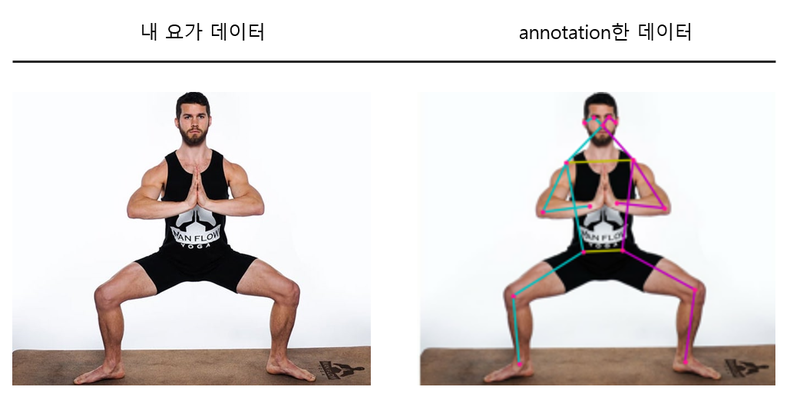

- 이제는 오른쪽 이미지처럼 annotation한 데이터처럼 keypoints들도 얻고 싶었습니다. 
- 실제로는 keypoints의 좌표를 사용하는 것입니다. 
- annotation한 데이터는 keypoints들과 그 keypoints들을 각각 연결하는 선을 시각화해두었습니다.

### 직접 annotation 해야 하는 걸까

- 우리는 이미지만 있기 때문에 keypoints를 직접 찍어줘야 한다.
- Annotaiton을 필요로하지 않는 모델들도 나오고 있지만, classification을 위해서 data annotation된 데이터가 필요한 경우가 많다.


- 또한 완벽한 label이 아닌, `coarse label`을 만들어 모델의 정확도가 향상되는지 보고 싶기 때문에, 
- 이미 존재하는 `keypoints detection 모델`을 사용해서 그 `inference 값`을 사용해보고자 한다.

### [MoveNet](https://www.tensorflow.org/hub/tutorials/movenet)

- MoveNet은 17개로 이루어진 바디 키포인트를 디텍팅하는 빠르고 정확한 모델
    - **Lightning**은 레이턴시(latency)가 중요한 어플리케이션을 위해 만들어졌고, 
    - **Thunder**는 높은 정확도를 요하는 어플리케이션을 위해 만들어졌습니다. 
    - KeyPoints 정보는 아래와 같다.
    
    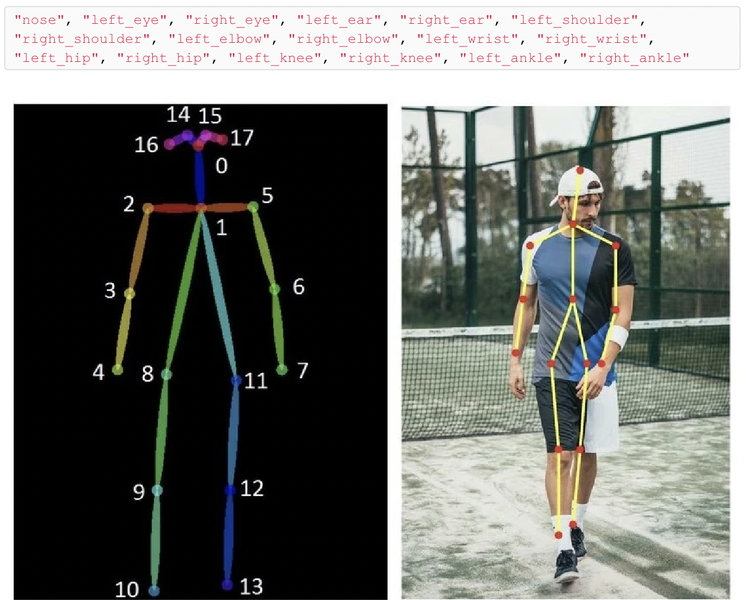

In [33]:
# !pip install -q imageio
# !pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs -qq

In [34]:
import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import cv2

# matplotlib 라이브러리 import
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# 이미지 display를 도와주는 imageio import
import imageio
from IPython.display import HTML, display

model_name = "movenet_lightning"

if "movenet_lightning" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")
    input_size = 192
elif "movenet_thunder" in model_name:
    module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
    input_size = 256
else:
    raise ValueError("Unsupported model name: %s" % model_name)

In [35]:
def movenet(module, input_image):
    """Runs detection on an input image.
    Args:
      input_image: A [1, height, width, 3] tensor represents the input image
        pixels. Note that the height/width should already be resized and match the
        expected input resolution of the model before passing into this function.
    Returns:
      A [1, 1, 17, 3] float numpy array representing the predicted keypoint
      coordinates and scores.
    """
    model = module.signatures['serving_default']

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores

## Annotation할 데이터 가져오기
- key point가 필요한 이미지 데이터를 불러옵니다.

In [36]:
from pathlib import Path

# 데이터 셋 위치
data_path = './model-fit/data/DATASET/TRAIN'
classes = [path for path in Path(data_path).iterdir() if path.is_dir()]
classes

[PosixPath('model-fit/data/DATASET/TRAIN/downdog'),
 PosixPath('model-fit/data/DATASET/TRAIN/goddess'),
 PosixPath('model-fit/data/DATASET/TRAIN/plank'),
 PosixPath('model-fit/data/DATASET/TRAIN/tree'),
 PosixPath('model-fit/data/DATASET/TRAIN/warrior2')]

In [37]:
train_files = []
for cls in classes:
    train_files += [x.as_posix() for x in Path(cls).glob('**/*') if x.is_file()]
train_files[:3], len(train_files)

(['model-fit/data/DATASET/TRAIN/downdog/00000274.jpg',
  'model-fit/data/DATASET/TRAIN/downdog/00000238.jpg',
  'model-fit/data/DATASET/TRAIN/downdog/00000199.jpg'],
 862)

In [38]:
data_path = './model-fit/data/DATASET/VAL'
classes = [path for path in Path(data_path).iterdir() if path.is_dir()]
val_files = []
for cls in classes:
    val_files += [x.as_posix() for x in Path(cls).glob('**/*') if x.is_file()]
val_files[:3], len(val_files)

(['model-fit/data/DATASET/VAL/downdog/00000274.jpg',
  'model-fit/data/DATASET/VAL/downdog/00000238.jpg',
  'model-fit/data/DATASET/VAL/downdog/00000199.jpg'],
 710)

In [39]:
data_path = './model-fit/data/DATASET/TEST'
classes = [path for path in Path(data_path).iterdir() if path.is_dir()]
test_files = []
for cls in classes:
    test_files += [x.as_posix() for x in Path(cls).glob('**/*') if x.is_file()]
test_files[:3], len(test_files)

(['model-fit/data/DATASET/TEST/downdog/00000041.png',
  'model-fit/data/DATASET/TEST/downdog/00000075.png',
  'model-fit/data/DATASET/TEST/downdog/00000126.jpg'],
 470)

## inference해서 json으로 저장하기

In [40]:
def get_keypoints(image, 
                  keypoints_with_scores,
                  output_image_height=None, 
                  keypoint_threshold=0.0):
    height, width, channel = image.shape
    aspect_ratio = float(width) / height

    keypoints_all = []
    num_instances,_,_,_ = keypoints_with_scores.shape
    for id in range(num_instances):
        kpts_x = keypoints_with_scores[0,id,:,1]
        kpts_y = keypoints_with_scores[0,id,:,0]
        kpts_scores = keypoints_with_scores[0,id,:,2]
        kpts_abs_xy = np.stack(
            [width*np.array(kpts_x),height*np.array(kpts_y)],axis=-1)
        kpts_above_thrs_abs = kpts_abs_xy[kpts_scores > keypoint_threshold,: ]
        keypoints_all.append(kpts_above_thrs_abs)

    return np.concatenate(keypoints_all,axis=0)

In [41]:
import json

def make_keypoints_json(files, module, input_size):
    keypoints = {}
    removed = []
    for image_path in files:
        # 이미지 에러에 대한 처리
        # 이미지가 tf.io.read_file로 읽을 수 없는 타입인 경우에 대비
        try:
            image = tf.io.read_file(image_path)
            image = tf.image.decode_jpeg(image)
        except:
            print('image error : ', image_path)
            removed.append(image_path)
            continue

        input_image = tf.expand_dims(image, axis=0)
        input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

        # 모델 인퍼런스 에러에 대한 처리
        try:
            keypoints_with_scores = movenet(module, input_image)
            # print(keypoints_with_scores)
        except Exception as e:
#             print(input_image.shape)
#             print('modl error : ', image_path)
            removed.append(image_path)
            continue

        keypoint_image = tf.expand_dims(image, axis=0)
        keypoint_image = tf.cast(tf.image.resize_with_pad(
            keypoint_image, 224, 224), dtype=tf.int32)
        output_overlay = get_keypoints(np.squeeze(keypoint_image.numpy(), axis=0), 
                                      keypoints_with_scores)
        # print(os.path.join('/'.join(image_path.split('/'))))
        keypoints.setdefault(os.path.join('/'.join(image_path.split('/'))), output_overlay.tolist())
        
    return keypoints, removed

In [42]:
train_keypoints, train_removed_files = make_keypoints_json(train_files, module, input_size)

Corrupt JPEG data: premature end of data segment


In [43]:
val_keypoints, val_removed_files = make_keypoints_json(val_files, module, input_size)

Corrupt JPEG data: premature end of data segment
Improper call to JPEG library in state 203


image error :  model-fit/data/DATASET/VAL/tree/00000114.jpg


In [44]:
test_keypoints, test_removed_files = make_keypoints_json(test_files, module, input_size)

```
modl error :  model-fit/data/DATASET/VAL/downdog/00000345.png
 input depth must be evenly divisible by filter depth: 4 vs 3
	 [[{{node StatefulPartitionedCall/center_net_mobile_net_v2fpn_feature_extractor/model_1/model/Conv1/Conv2D}}]] [Op:__inference_signature_wrapper_1747581]

Function call stack:
signature_wrapper
```

---
위와 같은 오류로 제대로 inference를 하지 못하는 경우가 생긴다.
나머지 이미지들은 **keypoints dictionary**를 확인하고 나머지 데이터에도 적용한다.

In [45]:
# # train, val keypoints 합쳐서 한 번에 저장하기
train_keypoints.update(val_keypoints)
train_keypoints.keys()
with open("./model-fit/keypoints_train_val.json", "w") as json_file:
    json.dump(train_keypoints, json_file)

In [46]:
# test keypoints 저장하기
with open("./model-fit/keypoints_test.json", "w") as json_file:
    json.dump(test_keypoints, json_file)

In [47]:
def remove_files(removed):
    for file_path in removed:
        try:
            os.remove(file_path)
        except:
            print(file_path)

In [48]:
remove_files(train_removed_files)
remove_files(val_removed_files)
remove_files(test_removed_files)

q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q
q


## 이미지 데이터와 keypoints 데이터를 로드하는 데이터로더 만들기
- 새 데이터로더는 image, label 형태가 아닌 **{"input_1": img, "input_2": keypoint}, label**로 데이터를 로드할 것이다.

In [49]:
keypoint = {}

def process_keypoint(file_path):
    global keypoint_dict
    file_path = file_path.numpy().decode('utf-8')
    file_path = os.path.join('./', file_path)
    keypoint = tf.convert_to_tensor(keypoint_dict[file_path], dtype=tf.float32)
    return keypoint

def process_path(file_path, class_names, img_shape=(224, 224)):
    label = tf.strings.split(file_path, os.path.sep)
    label = (label[-2] == class_names)
    label = tf.cast(label, tf.float32)

    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, img_shape) 

    [keypoint,] = tf.py_function(process_keypoint, [file_path], [tf.float32])

    return {"input_1": img, "input_2": keypoint}, label

def augment(inputs, label):
    image, keypoint = inputs['input_1'], inputs['input_2']
    image = tf.image.random_crop(image, size=[224, 224, 3])
    image = tf.image.adjust_brightness(image, 0.4)
    image = tf.image.random_brightness(image, max_delta=0.4)
    return {'input_1' : image, 'input_2' : keypoint}, label


def prepare_for_training(ds, batch_size=32, cache=True, shuffle_buffer_size=1000, training=True):
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    if training:
        ds = ds.map(lambda x, y: augment(x, y))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds


def load_label(data_path):
    class_names = [str(x) for x in data_path.iterdir()]
    print('Find {} class : {}'.format(len(class_names), class_names))
    return np.array(class_names)


def show_batch(image_batch, label_batch, class_names):
    size = len(image_batch)
    sub_size = int(size ** 0.5) + 1

    plt.figure(figsize=(10, 10), dpi=80)
    for n in range(size):
        plt.subplot(sub_size, sub_size, n+1)
        plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.5)
        plt.title(class_names[np.array(label_batch[n])==True][0].title())
        plt.imshow(image_batch[n])
    plt.show()


def load_data(data_path, img_shape=(224, 224), batch_size=32, training=True):
    class_names = [cls for cls in os.listdir(data_path) if cls != '.DS_Store']
    data_path = pathlib.Path(data_path)

    list_ds = tf.data.Dataset.list_files(str(data_path/'*/*'))
    labeled_ds = list_ds.map(lambda x: process_path(x, class_names, img_shape=img_shape))
    ds = prepare_for_training(labeled_ds, batch_size=batch_size)

    DATASET_SIZE = tf.data.experimental.cardinality(list_ds).numpy()

    global keypoint_dict
    if training:
        with open("./model-fit/keypoints_train_val.json", "r") as json_file:
            keypoint_dict = json.load(json_file)
    else:
        with open("./model-fit/keypoints_test.json", "r") as json_file:
            keypoint_dict = json.load(json_file)

    return ds, DATASET_SIZE

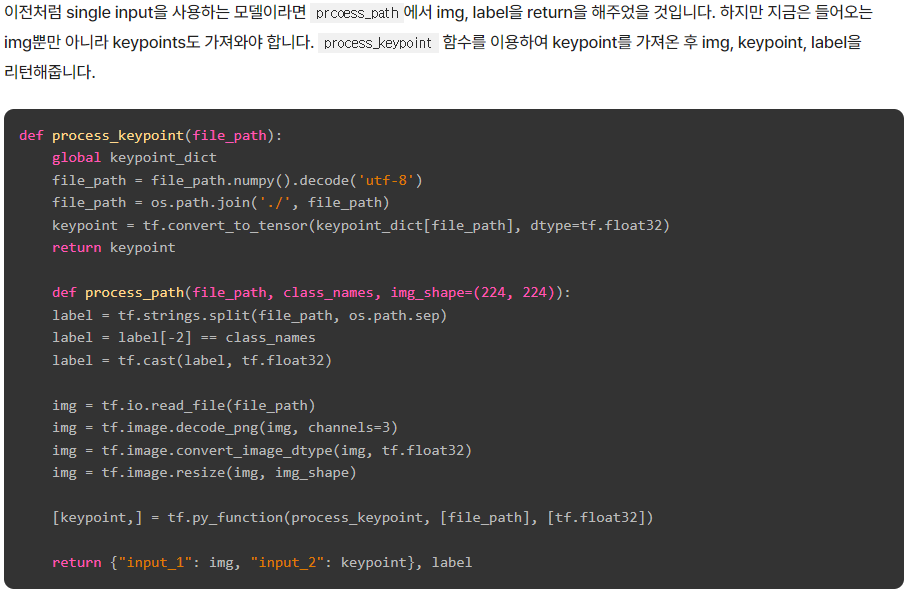

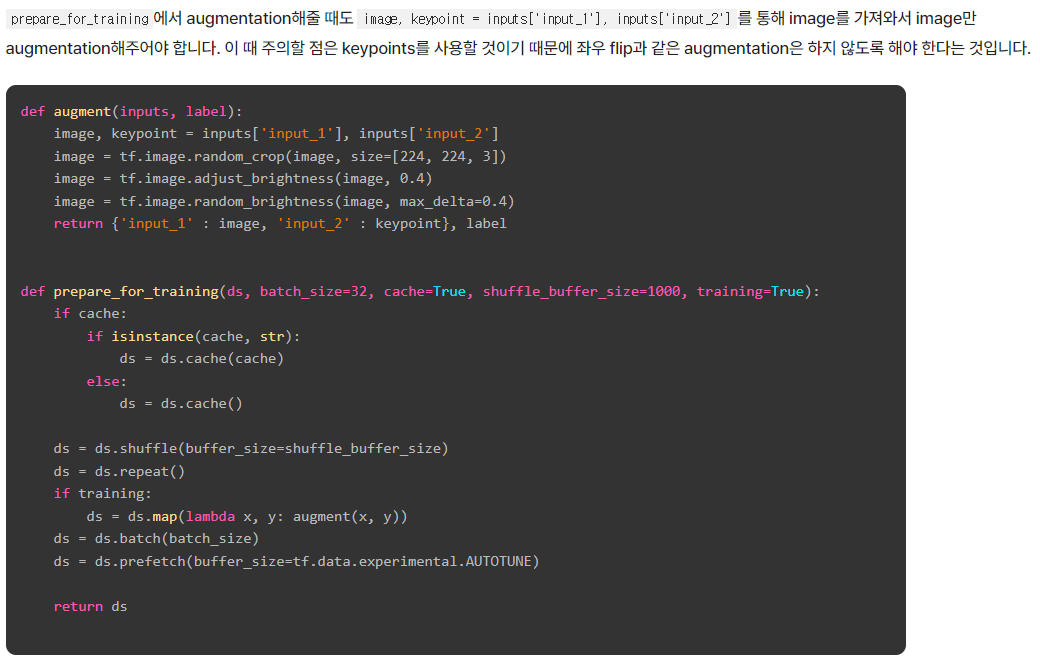

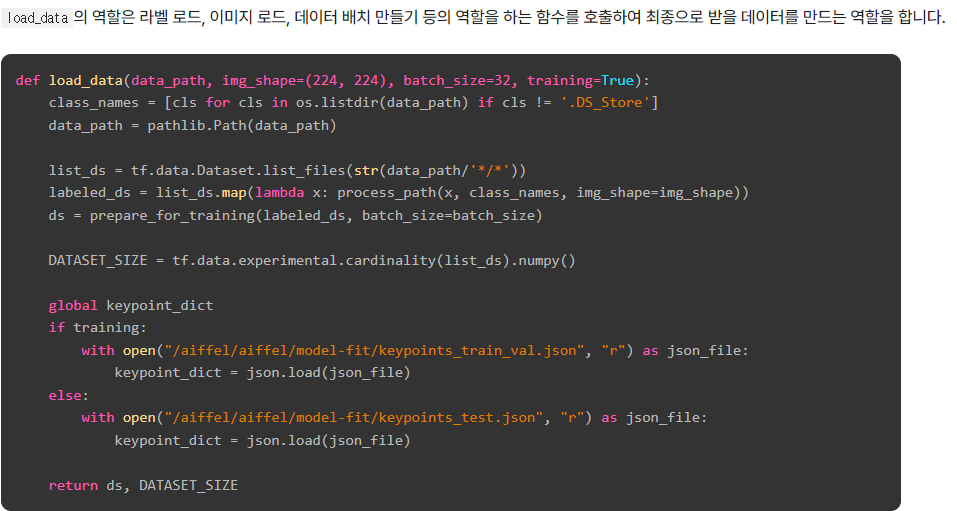

In [65]:
# 내 데이터 위치
train_data_path = './model-fit/data/DATASET/TRAIN/'

train_ds, train_size = load_data(data_path=train_data_path, img_shape=(224, 224), batch_size=1)

# for inputs in train_ds.take(1):
#     print(inputs)

train_ds.element_spec

({'input_1': TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  'input_2': TensorSpec(shape=<unknown>, dtype=tf.float32, name=None)},
 TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))

In [56]:
from tensorflow.keras.applications import VGG16

class YogaPose(tf.keras.Model):
    def __init__(self, num_classes=30, freeze=False):
        super(YogaPose, self).__init__()
        self.base_model = EfficientNetB0(include_top=False, weights='imagenet')
        self.keypoint = tf.keras.Sequential([tf.keras.layers.Flatten(input_shape=(17, 2)),
                                              tf.keras.layers.Dense(34),])
        
        if freeze:
            self.base_model.trainable = False

        self.top = tf.keras.Sequential([tf.keras.layers.GlobalAveragePooling2D(name="avg_pool"),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Dropout(0.6, name="top_dropout")])
        
        self.concat = tf.keras.layers.Concatenate(axis=-1)
        self.classifier = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")

    def call(self, inputs, training=True):
        image, keypoint = inputs['input_1'], inputs['input_2']
        x1 = self.base_model(image)
        x1 = self.top(x1)
        x2 = self.keypoint(keypoint)
        x = self.concat([x1, x2])
        x = self.classifier(x)
        return x

In [57]:
# 가짜 input
inputs = {'input_1':tf.ones([1, 224, 224, 3]), 'input_2':tf.ones([1, 17, 2])}
model = YogaPose(num_classes=2, freeze=True)
model(inputs)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.43848303, 0.56151694]], dtype=float32)>

In [58]:
from tensorflow.keras.utils import Progbar
import math

class Trainer:
    def __init__(self, model, epochs, batch, loss_fn, optimizer):
        self.model = model
        self.epochs = epochs
        self.batch = batch
        self.loss_fn = loss_fn
        self.optimizer = optimizer

    def compute_acc(self, y_pred, y):
        correct = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
        return accuracy

    @tf.function
    def train_on_batch(self, x_batch_train, y_batch_train):
        with tf.GradientTape() as tape:
            logits = model(x_batch_train, training=True)    # 모델이 예측한 결과
            train_loss = self.loss_fn(y_batch_train, logits)     # 모델이 예측한 결과와 GT를 이용한 loss 계산

        grads = tape.gradient(train_loss, model.trainable_weights)  # gradient 계산
        self.optimizer.apply_gradients(zip(grads, model.trainable_weights))  # Otimizer에게 처리된 그라데이션 적용을 요청

        return train_loss, logits

    def train(self, train_dataset, acc_metric, steps_per_epoch, val_dataset, val_step):
        metrics_names = ['train_loss', 'train_acc', 'val_loss']

        for epoch in range(self.epochs):
            print("\nEpoch {}/{}".format(epoch+1, self.epochs))

            train_dataset = train_dataset.shuffle(100)
            val_dataset = val_dataset.shuffle(100)

            train_dataset = train_dataset.take(steps_per_epoch)
            val_dataset = val_dataset.take(val_step)

            progBar = Progbar(steps_per_epoch * self.batch, stateful_metrics=metrics_names)

            train_loss, val_loss = 100, 100

            # 데이터 집합의 배치에 대해 반복합니다
            for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):
                train_loss, logits = self.train_on_batch(x_batch_train, y_batch_train)

                # train metric(mean, auc, accuracy 등) 업데이트
                acc_metric.update_state(y_batch_train, logits)

                train_acc = self.compute_acc(logits, y_batch_train)
                values = [('train_loss', train_loss), ('train_acc', train_acc)]
                # print('{}'.format((step_train + 1) * self.batch))
                progBar.update((step_train + 1) * self.batch, values=values)

            for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
                logits = model(x_batch_val, training=False)
                val_loss = self.loss_fn(y_batch_val, logits)
                val_acc = self.compute_acc(logits, y_batch_val)
                values = [('train_loss', train_loss), ('train_acc', train_acc), ('val_loss', val_loss), ('val_acc', val_acc)]
            progBar.update((step_train + 1) * self.batch, values=values, finalize=True)

In [59]:
train_data_path = './model-fit/data/DATASET/TRAIN' 
val_data_path = './model-fit/data/DATASET/VAL' 
batch_size = 16

train_ds, TRAIN_SIZE = load_data(data_path=train_data_path, img_shape=(224, 224), batch_size=batch_size)
val_ds, VAL_SIZE = load_data(data_path=val_data_path, img_shape=(224, 224), batch_size=batch_size)

In [60]:
compute_steps_per_epoch = lambda x: int(math.ceil(1. * x / batch_size))
steps_per_epoch = compute_steps_per_epoch(TRAIN_SIZE)
val_steps = compute_steps_per_epoch(VAL_SIZE)

In [61]:
loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)  
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001) 
acc_metric = tf.keras.metrics.CategoricalAccuracy()

model = YogaPose(num_classes=5)

# epoch을 조정해 보세요. 
trainer = Trainer(model=model,
                  epochs=10,
                  batch=1,
                  loss_fn=loss_function,
                  optimizer=optimizer,)

trainer.train(train_dataset=train_ds,
            steps_per_epoch=steps_per_epoch,
            val_step=val_steps,
            val_dataset=val_ds,
            acc_metric=acc_metric)


Epoch 1/10


UnknownError: KeyError: './model-fit/data/DATASET/TRAIN/warrior2/00000218.jpg'
Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 247, in __call__
    return func(device, token, args)

  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 135, in __call__
    ret = self._func(*args)

  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_31/1687355012.py", line 7, in process_keypoint
    keypoint = tf.convert_to_tensor(keypoint_dict[file_path], dtype=tf.float32)

KeyError: './model-fit/data/DATASET/TRAIN/warrior2/00000218.jpg'


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]

In [62]:
num_classes = 5
epoch = 1 
batch_size = 16
img_size = 224
test_data_path =  './model-fit/data/DATASET/TEST'

checkpoint_path = './checkpoints/'

model = YogaPose(num_classes=num_classes)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

test, TEST_SIZE = load_data(data_path=test_data_path, img_shape=(img_size, img_size), batch_size=batch_size, training=False)

checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_path))

for step_train, (x_batch_train, y_batch_train) in enumerate(test.take(10)):
    # print(model(x_batch_train))
    prediction = model(x_batch_train)
    # print(tf.argmax(y_batch_train, axis=1))
    # print(tf.argmax(prediction, axis=1))
    # print(tf.equal(tf.argmax(y_batch_train, axis=1), tf.argmax(prediction, axis=1)))
    print("{}/{}".format(np.array(tf.equal(tf.argmax(y_batch_train, axis=1), tf.argmax(prediction, axis=1))).sum(), tf.argmax(y_batch_train, axis=1).shape[0]))
    # print("Prediction: {}".format(tf.argmax(prediction, axis=1)))

UnknownError: KeyError: './model-fit/data/DATASET/TEST/tree/00000030.jpg'
Traceback (most recent call last):

  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 247, in __call__
    return func(device, token, args)

  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/script_ops.py", line 135, in __call__
    ret = self._func(*args)

  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/autograph/impl/api.py", line 645, in wrapper
    return func(*args, **kwargs)

  File "/tmp/ipykernel_31/1687355012.py", line 7, in process_keypoint
    keypoint = tf.convert_to_tensor(keypoint_dict[file_path], dtype=tf.float32)

KeyError: './model-fit/data/DATASET/TEST/tree/00000030.jpg'


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]